In [1]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
sys.path.insert(0,  os.path.dirname(os.path.dirname(os.getcwd()) ))
from Dataset import SROIEDataset2
from torch.utils.data import DataLoader
from tqdm import tqdm
from ctpn_model import *

In [37]:
train_dataset = SROIEDataset2('train','../../data/train/img','../../data/train/box',  )
val_dataset = SROIEDataset2('val','../../data/train/img','../../data/train/box',  )
test_dataset = SROIEDataset2(None, '../../data/test/img','../../data/test/box', )

sub_train_dataset = [train_dataset[i] for i in range(10)]
sub_val_dataset = [val_dataset[i] for i in range(10) ]



In [45]:
class DatasetToMemory(SROIEDataset2):
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        m_img, cls, regr, _ = self.dataset[idx]
        return m_img, cls, regr

train_dataset_l = DatasetToMemory(sub_train_dataset)
val_dataset_l = DatasetToMemory(sub_val_dataset)

train_loader = DataLoader(train_dataset_l, batch_size=5,)
val_loader = DataLoader(val_dataset_l, batch_size=2,)

In [46]:
# train_loader_spec[8][0] , sub_train_dataset[8][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


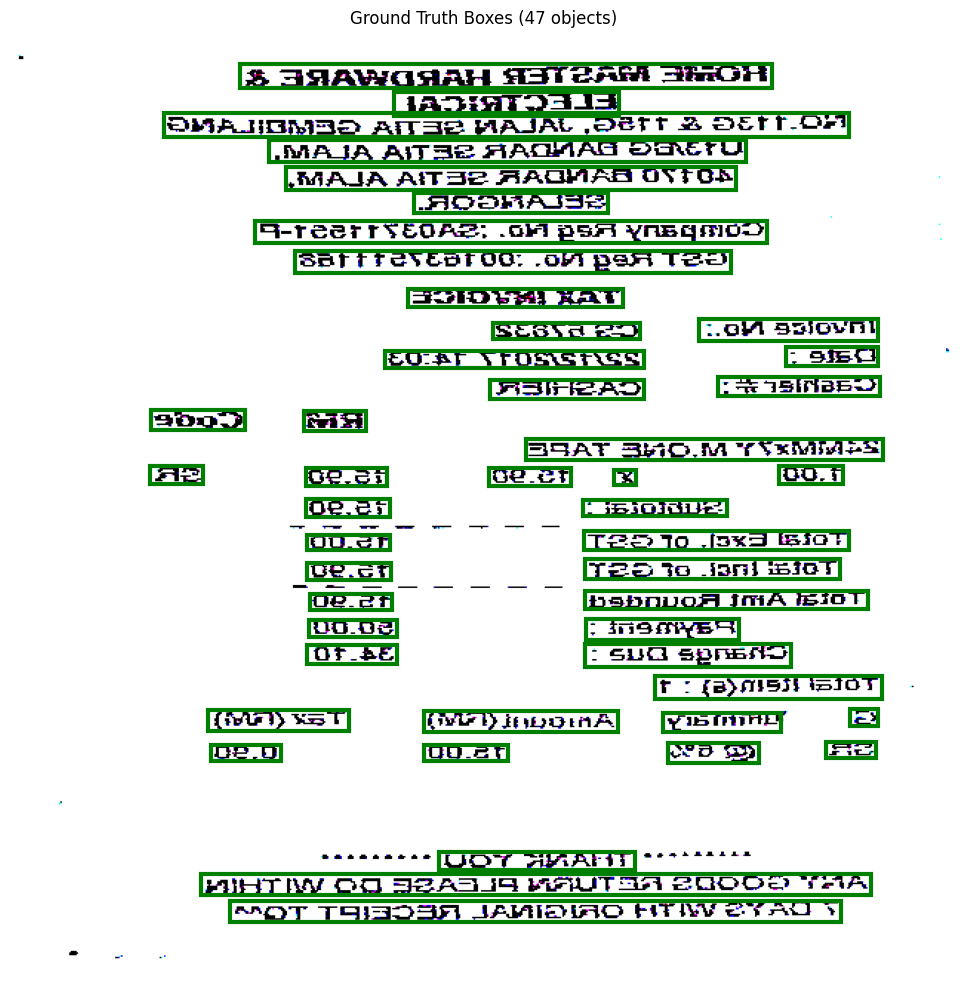

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

def visualize_sample_data(m_img, gtbox):
    """
    Визуализация данных из одного сэмпла датасета
    
    Args:
        m_img: нормализованное изображение [3, H, W] или [H, W, 3]
        cls: классификатор анкоров
        regr: регрессия анкоров  
        gtbox: ground truth boxes [num_boxes, 4] в формате (x1, y1, x2, y2)
    """


    # Обрезаем значения и конвертируем
    img_np = m_img.cpu().numpy().transpose(1, 2, 0)

    # 2. Создаем визуализацию
    #print(m_img.shape)

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    
    # 2a. Левая панель: только GT boxes
    ax.imshow(img_np)

    if gtbox is not None and len(gtbox) > 0:
        gtbox_np = gtbox if isinstance(gtbox, np.ndarray) else gtbox.cpu().numpy()
        
        for i, box in enumerate(gtbox_np):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            rect = plt.Rectangle(
                (x1, y1), width, height,
                fill=False, edgecolor='green', linewidth=3,
                label='Ground Truth' if i == 0 else ""
            )
            ax.add_patch(rect)
    
    ax.set_title(f'Ground Truth Boxes ({len(gtbox) if gtbox is not None else 0} objects)')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()


img, _, _, boxes = train_dataset[11]
visualize_sample_data(img, boxes)

In [48]:
len(train_dataset), len(val_dataset), len(test_dataset)

(563, 63, 347)

In [49]:
def train_epoch(model, dataloader, critetion_cls, critetion_regr,
                optimizer, device, epoch):
    """Одна эпоха обучения для полной CTPN модели"""
    model.train()

    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}')

    epoch_size = len(dataloader) // 1
    epoch_loss_cls = 0
    epoch_loss_regr = 0
    epoch_loss = 0

    for batch_idx, (imgs, clss, regrs) in enumerate(progress_bar):
            # Перенос изображений на устройство
            imgs = imgs.to(device)
            clss = clss.to(device)
            regrs = regrs.to(device)

            out_cls, out_regr = model(imgs)
            loss_cls = critetion_cls(out_cls, clss)
            loss_regr = critetion_regr(out_regr, regrs)

            loss = loss_cls + loss_regr  # total loss
            loss.backward()
            optimizer.step()
    
            epoch_loss_cls += loss_cls.item()
            epoch_loss_regr += loss_regr.item()
            epoch_loss += loss.item()
            mmp = batch_idx + 1
    epoch_loss_cls /= epoch_size
    epoch_loss_regr /= epoch_size
    epoch_loss /= epoch_size

    
            
    # Обновление progress bar
    progress_bar.set_postfix({
                'loss': epoch_loss,
                'cls': epoch_loss_cls,
                'reg': epoch_loss_regr
    })
            

    return epoch_loss_cls, epoch_loss_regr, epoch_loss


def validate_epoch(model, val_loader, critetion_cls, critetion_regr, device):
    """Валидационная эпоха по аналогии с train_epoch"""
    model.eval()
    
    progress_bar = tqdm(val_loader, desc='Validation')
    
    epoch_size = len(val_loader) // 1
    epoch_loss_cls = 0
    epoch_loss_regr = 0
    epoch_loss = 0
    
    with torch.no_grad():
        for batch_idx, (imgs, clss, regrs)  in enumerate(progress_bar):
            # Перенос данных на устройство
            imgs = imgs.to(device)
            clss = clss.to(device)
            regrs = regrs.to(device)
            
            # Forward pass
            out_cls, out_regr = model(imgs)
            
            # Вычисление лоссов
            loss_cls = critetion_cls(out_cls, clss)
            loss_regr = critetion_regr(out_regr, regrs)
            loss = loss_cls + loss_regr
            
            # Накопление статистики
            epoch_loss_cls += loss_cls.item()
            epoch_loss_regr += loss_regr.item()
            epoch_loss += loss.item()
            
            # Обновление progress bar
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'cls': f"{loss_cls.item():.4f}",
                'reg': f"{loss_regr.item():.4f}"
            })
    
    # Средние значения за эпоху
    mmp = batch_idx + 1 if batch_idx >= 0 else 1
    epoch_loss_cls /= mmp
    epoch_loss_regr /= mmp
    epoch_loss /= mmp
    

    return epoch_loss_cls, epoch_loss_regr, epoch_loss


def train_model(model, train_loader, val_loader, critetion_cls, critetion_regr, optimizer, 
                device, num_epochs=10):
    """
    Обучение модели CTPN с сохранением лучшей модели по валидации
    """
    # Перемещаем модель на устройство
    model = model.to(device)

    # История обучения
    history = {
        'train_total': [], 
        'train_cls': [], 
        'train_reg': [], 
        'val_total': [], 'val_cls': [], 'val_reg': [], 
        'best_val_loss': float('inf'),

    }
    
    # Общий прогресс-бар для эпох
    epoch_pbar = tqdm(range(num_epochs), desc='Training', unit='epoch')
    
    for epoch in epoch_pbar:
        epoch_num = epoch + 1
        
        # Обучение
        train_losses = train_epoch(model, train_loader, critetion_cls, critetion_regr,
                optimizer, device, epoch)
        
        epoch_loss_cls, epoch_loss_regr, epoch_loss = train_losses
        
        # Валидация
        val_losses = validate_epoch(model, val_loader, critetion_cls, critetion_regr, device)

        v_epoch_loss_cls, v_epoch_loss_regr, v_epoch_loss  = val_losses
        
        # Сохраняем историю
        history['train_total'].append(epoch_loss)
        history['train_cls'].append(epoch_loss_cls)
        history['train_reg'].append(epoch_loss_regr)

        
        history['val_total'].append(v_epoch_loss)
        history['val_cls'].append(v_epoch_loss_cls)
        history['val_reg'].append(v_epoch_loss_regr)

        
        # Сохраняем лучшую модель
        if v_epoch_loss < history['best_val_loss']:
            history['best_val_loss'] = v_epoch_loss
            history['best_epoch'] = epoch_num
            
            # Сохраняем модель
            torch.save({
                'epoch': epoch_num,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': epoch_loss,
                'val_loss': v_epoch_loss,
                'history': history
            }, 'best_ctpn_model.pth')
        
        # Обновляем описание progress bar
        epoch_pbar.set_postfix({
            'train_loss': f'{v_epoch_loss:.4f}',
            'val_loss': f'{v_epoch_loss:.4f}',
            'best_val': f'{history["best_val_loss"]:.4f}',
            'best_ep': history['best_epoch']
        })
    return history


In [50]:
model = CTPN_Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
critetion_cls = RPN_CLS_Loss(device)
model.to(device)
critetion_regr = RPN_REGR_Loss(device)

/Users/kimelfeld/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kimelfeld/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [51]:
history = train_model(model, train_loader,  
                    val_loader, critetion_cls, critetion_regr,
                    optimizer, device, num_epochs=2)

Training:   0%|          | 0/2 [00:00<?, ?epoch/s]


Epoch 0: 100%|██████████| 2/2 [00:28<00:00, 14.41s/it]











Training:  50%|█████     | 1/2 [00:36<00:36, 36.39s/epoch, train_loss=1.1243, val_loss=1.1243, best_val=1.1243, best_ep=1]


Epoch 1: 100%|██████████| 2/2 [00:26<00:00, 13.41s/it]











Training: 100%|██████████| 2/2 [01:10<00:00, 35.36s/epoch, train_loss=1.1228, val_loss=1.1228, best_val=1.1228, best_ep=2]


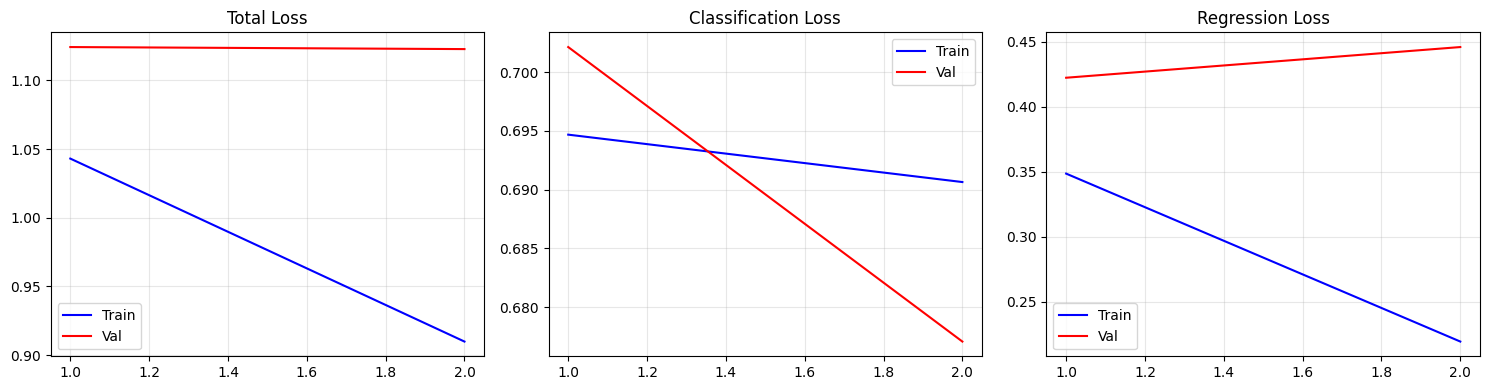

In [52]:
import matplotlib.pyplot as plt

def visualize_training_simple(history):
    """
    Простая визуализация обучения - только графики и подписи линий.
    """
    epochs = range(1, len(history['train_total']) + 1)
    
    # Создаем графики
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Total Loss
    axes[0].plot(epochs, history['train_total'], 'b-', label='Train')
    axes[0].plot(epochs, history['val_total'], 'r-', label='Val')
    axes[0].set_title('Total Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Classification Loss
    axes[1].plot(epochs, history['train_cls'], 'b-', label='Train')
    axes[1].plot(epochs, history['val_cls'], 'r-', label='Val')
    axes[1].set_title('Classification Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Regression Loss
    axes[2].plot(epochs, history['train_reg'], 'b-', label='Train')
    axes[2].plot(epochs, history['val_reg'], 'r-', label='Val')
    axes[2].set_title('Regression Loss')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_training_simple(history)

In [53]:

def show_image(image):   
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [ ]:
from task1_utils.ctpn_utils import *
import numpy

prob_thresh = 0.3
iou_tresh = 0.4

image = cv2.imread('../../data/train/img/X51007339165.jpg')

IMAGE_MEAN = [123.68, 116.779, 103.939]

image = image.astype(np.float32) - IMAGE_MEAN


h, w = image.shape[:2]
image_c = image.copy()
image = torch.from_numpy(image.transpose(2, 0, 1)).unsqueeze(0).float()

with torch.no_grad():
    image = image.to(device)
    cls, regr = model(image)
    cls_prob = F.softmax(cls, dim=-1).cpu().numpy()
    regr = regr.cpu().numpy()
    anchor = gen_anchor((int(h / 8), int(w / 8)), 8)

    bbox = bbox_transfor_inv(anchor, regr)
    bbox = clip_box(bbox, [h, w])

    fg = np.where(cls_prob[0, :, 1] > prob_thresh)[0]
    select_anchor = bbox[fg, :]
    select_score = cls_prob[0, fg, 1]
    select_anchor = select_anchor.astype(np.int32)

    keep_index = filter_bbox(select_anchor, 8)

    # nsm
    select_anchor = select_anchor[keep_index]
    select_score = select_score[keep_index]
    select_score = np.reshape(select_score, (select_score.shape[0], 1))
    nmsbox = np.hstack((select_anchor, select_score))

    keep = nms(nmsbox, iou_tresh)

    select_anchor = select_anchor[keep]
    select_score = select_score[keep]

    # text line-
    textConn = TextProposalConnectorOriented()
    text = textConn.get_text_lines(select_anchor, select_score, [h, w])


#     for i in text:
#         print(i)
#         s = str(round(i[-1] * 100, 2)) + '%'
#         i = [int(j) for j in i]
#         cv2.line(image_c, (i[0], i[1]), (i[2], i[3]), (0, 0, 255), 2)
#         cv2.line(image_c, (i[0], i[1]), (i[4], i[5]), (0, 0, 255), 2)
#         cv2.line(image_c, (i[6], i[7]), (i[2], i[3]), (0, 0, 255), 2)
#         cv2.line(image_c, (i[4], i[5]), (i[6], i[7]), (0, 0, 255), 2)
#         cv2.putText(image_c, s, (i[0]+13, i[1]+13),
#                     cv2.FONT_HERSHEY_SIMPLEX,
#                     1,
#                     (255,0,0),
#                     2,
#                     cv2.LINE_AA)
    
    

# show_image(image_c)

print(f"До NMS: {len(fg)} боксов (conf > {prob_thresh})")
print(f"После NMS: {len(keep)} боксов (conf > {prob_thresh}, IoU < {iou_tresh})")
print(f"Удалено: {len(fg) - len(keep)} дублирующихся детекций")


До NMS: 154000 боксов (conf > 0.3)
После NMS: 21127 боксов (conf > 0.3, IoU < 0.4)
Удалено: 132873 дублирующихся детекций


In [104]:
def quads_to_boxes(text):
    boxes = []
    for t in text:
        # t[:8] содержит 8 координат: x1, y1, x2, y2, x3, y3, x4, y4
        coords = t[:8]
        
        # Разделяем координаты на X и Y
        x_coords = [coords[i] for i in range(0, 8, 2)]  # x1, x2, x3, x4
        y_coords = [coords[i] for i in range(1, 8, 2)]  # y1, y2, y3, y4
        
        # Находим min и max для каждой оси
        x_min = min(x_coords)
        y_min = min(y_coords)
        x_max = max(x_coords)
        y_max = max(y_coords)
        
        boxes.append([x_min, y_min, x_max, y_max, t[-1]])
    
    return boxes

def pred_box_postproccesing(image, model, prob_thresh, iou_tresh):
    image = image.unsqueeze(0).to(device)
    cls, regr = model(image)
    cls_prob = F.softmax(cls, dim=-1).cpu().numpy()
    regr = regr.cpu().numpy()
    h, w = 640, 640
    #
    anchor = gen_anchor((int(h / 8), int(w / 8)), 8)
    bbox = bbox_transfor_inv(anchor, regr)
    bbox = clip_box(bbox, [h, w])
    fg = np.where(cls_prob[0, :, 1] > prob_thresh)[0]
    select_anchor = bbox[fg, :]
    select_score = cls_prob[0, fg, 1]
    select_anchor = select_anchor.astype(np.int32)
    keep_index = filter_bbox(select_anchor, 8)

    # nsm
    select_anchor = select_anchor[keep_index]
    select_score = select_score[keep_index]
    select_score = np.reshape(select_score, (select_score.shape[0], 1))
    nmsbox = np.hstack((select_anchor, select_score))
    keep = nms(nmsbox, iou_tresh)

    select_anchor = select_anchor[keep]
    select_score = select_score[keep]

    # text line-
    textConn = TextProposalConnectorOriented()
    text = textConn.get_text_lines(select_anchor, select_score, [h, w])
    nms_boxes = quads_to_boxes(text)
    return nms_boxes
    

In [105]:
# [tuple(a[:2]) for a in [['b', 'a','c'], ['b', 'f','d']]]


In [106]:
def calculate_iou(box1, box2):
    """
    Вычисляет Intersection over Union (IoU) между двумя боксами

    """
    x1_min, y1_min, x1_max, y1_max = box1[:4]
    x2_min, y2_min, x2_max, y2_max = box2[:4]
    
    # Вычисляем площадь пересечения
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)
    
    if inter_x_max <= inter_x_min or inter_y_max <= inter_y_min:
        return 0.0
    
    inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
    
    # Вычисляем площадь объединения
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area
    
    if union_area == 0:
        return 0.0
    
    iou = inter_area / union_area
    return iou

def calculate_map(pred_boxes_list, gt_boxes_list, iou_threshold=0.5, conf_threshold=0.5):
    """
    Вычисляет mAP (mean Average Precision) для детекции объектов

    """
    all_detections = []
    all_ground_truths = []
    
    # Собираем все детекции и ground truth
    for pred_boxes, gt_boxes in zip(pred_boxes_list, gt_boxes_list):
        # Фильтруем по confidence
        filtered_pred = [(box[0], box[1], box[2], box[3], box[4]) 
                        for box in pred_boxes if box[4] >= conf_threshold]
        
        # Сортируем по confidence (убывание)
        filtered_pred.sort(key=lambda x: x[4], reverse=True)
        
        all_detections.append(filtered_pred)
        all_ground_truths.append([(box[0], box[1], box[2], box[3]) for box in gt_boxes])
    
    # Вычисляем TP и FP для каждого изображения
    tp_list = []
    fp_list = []
    scores_list = []
    
    for pred_boxes, gt_boxes in zip(all_detections, all_ground_truths):
        if len(gt_boxes) == 0:
            # Если нет ground truth, все предсказания - False Positive
            tp_list.extend([0] * len(pred_boxes))
            fp_list.extend([1] * len(pred_boxes))
            scores_list.extend([box[4] for box in pred_boxes])
            continue
        
        # Массив для отслеживания, какие ground truth уже использованы
        gt_used = [False] * len(gt_boxes)
        
        tp = []
        fp = []
        scores = []
        
        for pred_box in pred_boxes:
            pred_coords = pred_box[:4]
            best_iou = 0
            best_gt_idx = -1
            
            # Находим лучший matching ground truth
            for gt_idx, gt_box in enumerate(gt_boxes):
                if gt_used[gt_idx]:
                    continue
                iou = calculate_iou(pred_coords, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx
            
            # Определяем TP или FP
            if best_iou >= iou_threshold:
                tp.append(1)
                fp.append(0)
                gt_used[best_gt_idx] = True
            else:
                tp.append(0)
                fp.append(1)
            
            scores.append(pred_box[4])
        
        tp_list.extend(tp)
        fp_list.extend(fp)
        scores_list.extend(scores)
    
    # Сортируем по confidence (убывание)
    sorted_indices = sorted(range(len(scores_list)), key=lambda i: scores_list[i], reverse=True)
    tp_sorted = [tp_list[i] for i in sorted_indices]
    fp_sorted = [fp_list[i] for i in sorted_indices]
    
    # Вычисляем cumulative TP и FP
    tp_cumsum = np.cumsum(tp_sorted)
    fp_cumsum = np.cumsum(fp_sorted)
    
    # Вычисляем общее количество ground truth
    total_gt = sum(len(gt) for gt in all_ground_truths)
    
    # Вычисляем Precision и Recall
    precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)
    recall = tp_cumsum / (total_gt + 1e-8)
    
    # Вычисляем AP (Average Precision) - площадь под кривой Precision-Recall
    # Используем метод интерполяции (11-point interpolation)
    ap = 0
    for t in np.arange(0, 1.1, 0.1):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 11.0
    
    return ap, precision, recall


In [107]:
from PIL import Image
def evaluate_model_map(model, valid_dataset, 
                       device, img_size=640, conf_threshold=0.5, iou_threshold=0.4):
    """
    Оценивает модель на валидационном наборе и вычисляет mAP

    """
    model.eval()
    all_pred_boxes = []
    all_gt_boxes = []
    
    with torch.no_grad():
        for idx in tqdm(range(len(valid_dataset)), desc="Evaluating"):
            m_img, _, _, gtboxes = valid_dataset[idx]
            img_file = valid_dataset.image_files[idx]
  
            img_path = os.path.join(valid_dataset.image_dir, img_file)
            img = Image.open(img_path)
        
            original_size = img.size

            nms_boxes = pred_box_postproccesing(m_img, model, iou_tresh=iou_threshold, prob_thresh=conf_threshold)
            
            scale_x = original_size[0] / img_size
            scale_y = original_size[1] / img_size

            scaled_pred_boxes = []
            for x_min, y_min, x_max, y_max, conf in nms_boxes:
                x_min_scaled = x_min * scale_x
                y_min_scaled = y_min * scale_y
                x_max_scaled = x_max * scale_x
                y_max_scaled = y_max * scale_y
                scaled_pred_boxes.append((x_min_scaled, y_min_scaled, x_max_scaled, y_max_scaled, conf))
            
            all_pred_boxes.append(scaled_pred_boxes)
            all_gt_boxes.append(gtboxes.tolist())
    
    
    mAP, precision, recall = calculate_map(all_pred_boxes, all_gt_boxes, 
                                          iou_threshold=iou_threshold, 
                                          conf_threshold=conf_threshold)
    
    return mAP, precision, recall, all_pred_boxes, all_gt_boxes


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

mAP, precision, recall, all_pred_boxes, all_gt_boxes = evaluate_model_map(model, val_dataset, device)


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

torch.Size([3, 640, 640])


Evaluating:   2%|▏         | 1/63 [00:07<08:14,  7.97s/it]

torch.Size([3, 640, 640])


Evaluating:   3%|▎         | 2/63 [00:15<07:59,  7.86s/it]

torch.Size([3, 640, 640])


Evaluating:   5%|▍         | 3/63 [00:23<07:53,  7.89s/it]

torch.Size([3, 640, 640])


Evaluating:   6%|▋         | 4/63 [00:31<07:47,  7.92s/it]

torch.Size([3, 640, 640])


Evaluating:   6%|▋         | 4/63 [00:32<08:00,  8.14s/it]


KeyboardInterrupt: 